In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
init_notebook_mode(connected=True)

In [3]:
pokemons = pd.read_csv('kaggle/input/pokemondata/pokemon.csv')
numbers = []
for i in range(1,pokemons.shape[0]+1):
    numbers.append(i)
pokemons['pkn'] = numbers
IMG_DIR = 'kaggle/input/pokemonimage/pokemon/pokemon'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(IMG_DIR) if isfile(join(IMG_DIR, f))]

In [4]:
import re
dataframe_img = pd.DataFrame([])
images = []
pokemon_number = []
for img in onlyfiles:
    if not re.search('-', img):
        pkn = img.split('.')
        n = re.sub("[^0-9]", "", pkn[0])
        path = IMG_DIR +'/' +str(img)
        images.append(path)
        pokemon_number.append(n)
dataframe_img['images'] = images
dataframe_img['pkn'] = pokemon_number
dataframe_img['pkn'] = dataframe_img['pkn'].astype(int)
dataframe_img['pkn'] = dataframe_img['pkn'].astype(int)
result = pokemons.merge(dataframe_img, left_on='pkn', right_on='pkn')
result.head()

,Name,Type1,Type2,pkn,images
0,bulbasaur,Grass,Poison,1,kaggle/input/pokemonimage/pokemon/pokemon/1.png
1,ivysaur,Grass,Poison,2,kaggle/input/pokemonimage/pokemon/pokemon/2.png
2,venusaur,Grass,Poison,3,kaggle/input/pokemonimage/pokemon/pokemon/3.png
3,charmander,Fire,NaN,4,kaggle/input/pokemonimage/pokemon/pokemon/4.png
4,charmeleon,Fire,NaN,5,kaggle/input/pokemonimage/pokemon/pokemon/5.png


In [5]:
select = ['Water', 'Fire']
result = result[result['Type1'].isin(select)]
fig = go.Figure()

fig.add_trace(go.Bar(x=[result['Type1'].value_counts().index[0]],
                     y=[result['Type1'].value_counts()[0]],
                     marker_color='blue',
                     name='water'
                     ))

fig.add_trace(go.Bar(x=[result['Type1'].value_counts().index[1]],
                     y=[result['Type1'].value_counts()[1]],
                     marker_color='red',
                     name='fire'
                    ))
fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'title': 'Pokemon Distribution',
        'width': 500, 
        'height': 400
})
fig.show()

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    result, result['Type1'],test_size=0.33, stratify=result['Type1'])

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.33,stratify=y_test)

In [12]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

train = datagen.flow_from_directory('train/')
test = datagen.flow_from_directory('test/')
val = datagen.flow_from_directory('val/')

Found 136 images belonging to 2 classes.
Found 63 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Lambda
from keras.preprocessing.image import ImageDataGenerator

def build():
    model = Sequential()
    IMAGE_WIDTH = 256
    IMAGE_HEIGHT = 256
    IMAGE_CHANNELS = 3
    model.add(Lambda(lambda x: x, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (2, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    model.summary()
    return model
model = build()
history = model.fit_generator(train, epochs=30, validation_data=val)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 255, 255, 32)      416       
_________________________________________________________________
batch_normalization_8 (Batch (None, 255, 255, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 84, 84, 64)        8256      
_________________________________________________________________
batch_normalization_9 (Batch (None, 84, 84, 64)       

In [15]:
predict = model.predict(test)

In [16]:
fig = go.Figure()
epochs = []
for i in range(len(history.history['acc'])):
    epochs.append(i)
fig.add_trace(go.Scatter(x=epochs,y=history.history['acc'], mode='lines',name='train'))
fig.add_trace(go.Scatter(x=epochs,y=history.history['val_acc'], mode='lines',name='val'))
fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',
        'width': 500, 
        'height': 400

})
fig.show()

In [22]:
from sklearn.metrics import classification_report
predict_frame = pd.DataFrame([])
predict_frame['category'] = np.argmax(predict, axis=-1)
labels = dict((v,k) for k,v in val.class_indices.items())
predict_frame['category'] = predict_frame['category'].replace(labels)

In [23]:
def show_wrong_classification(y_test, predict, result):
    tmp = result[result.index.isin(y_test.index)]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
    i=0
    for imag, true, pred in zip(tmp['images'], tmp['Type1'], predict):
        if true!=pred:
            if i <3:
                img = Image.open(imag)
                fig = plt.figure()
                ax[i].imshow(img)
                ax[i].set_title(str(pred))
                i+=1

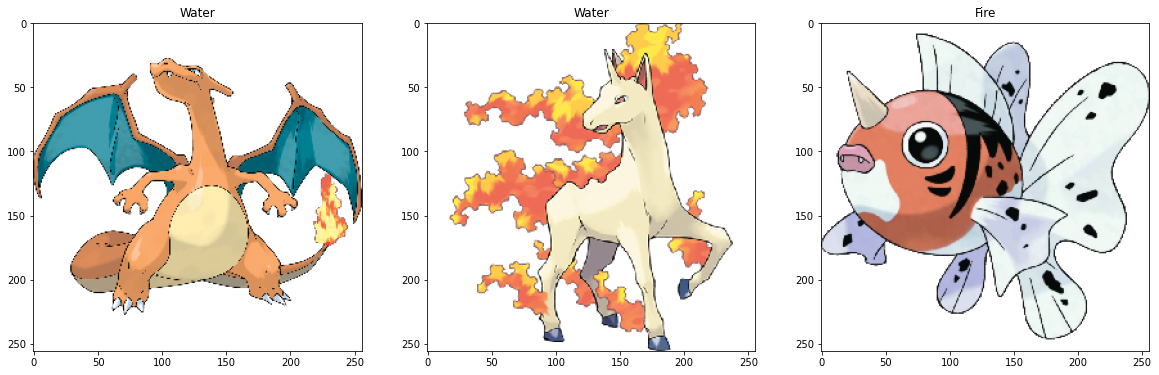

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [26]:
from PIL import Image
show_wrong_classification(y_test, predict_frame['category'], result)